# <font size="4"> Import dependencies </font>

In [1]:
import cdsapi
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 
import xgboost as xgb
import joblib
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
from colorama import Fore
import seaborn as sns
from scipy.interpolate import griddata

# <font size="4"> Import datasets</font>

In [2]:
#Import datasets

ERA_path = "../data/ERA5_data.nc"
JPL_path = "../data/JPL_Mascon_Grace.nc"
# read-print dataset
ds_era5= xr.open_dataset(ERA_path)
ds_JPL = xr.open_dataset(JPL_path)

# <font size="4"> Data Slicing to Region of Interest </font>

In [3]:
# Data slicing to Area of Interest

print("Input Area of Interest extend latΕ[-90,90], lonΕ[-180,180]")
try:
    lat_min = float(input("Latitude Min : "))
    lat_max = float(input("Latitude Max : "))
    lon_min = float(input("Longitude Min : "))
    lon_max = float(input("Longitude Max : "))
except ValueError:
    print("Wrong input! Please insert a number!")
print(f"\nArea of Interest: Lat[{lat_min}, {lat_max}], Lon[{lon_min}, {lon_max}]")

# Slice function
def slice_nc(ds, ds_name):
    print(f"\nSlicing {ds_name}")

    possible_lat_names = ['lat', 'latitude']
    possible_lon_names = ['lon', 'longitude']
    
    lat_name = None
    lon_name = None

    print("Checking for possible lat/lon names ")
    for name in ds.coords:
        # Checking with .lower() for possible lat/lon names
        if name.lower() in possible_lat_names:
            lat_name = name
        elif name.lower() in possible_lon_names:
            lon_name = name
    
    if not lat_name or not lon_name:
        raise ValueError(f" ERROR: There are no lat/lon columns in {ds_name}")

    # Converting Longitude (0-360 -> -180,180) ---
    if ds[lon_name].max() > 180:
        print(" Converting Longitude in -180,180")
        ds = ds.assign_coords({lon_name: (((ds[lon_name] + 180) % 360) - 180)})
    ds = ds.sortby(lon_name)

    # Check convertion
    lat_values = ds[lat_name].values  
    # Sorting
    if lat_values[0] > lat_values[-1]: 
        lat_slice = slice(lat_max, lat_min)
    else:
        lat_slice = slice(lat_min, lat_max)

    # Final slice to Area of Interest
    ds_sliced = ds.sel({
        lat_name: lat_slice, 
        lon_name: slice(lon_min, lon_max)
    })
    return ds_sliced

ds_era5_sliced = slice_nc(ds_era5,"ERA5")
ds_grace_JPL_sliced = slice_nc(ds_JPL, "GRACE")
print(f"\nCreated a data slice to the area of interest: Lat[{lat_min}, {lat_max}], Lon[{lon_min}, {lon_max}] ")

Input Area of Interest extend latΕ[-90,90], lonΕ[-180,180]

Area of Interest: Lat[-17.0, 5.0], Lon[-80.0, -50.0]

Slicing ERA5
Checking for possible lat/lon names 
 Converting Longitude in -180,180

Slicing GRACE
Checking for possible lat/lon names 
 Converting Longitude in -180,180

Created a data slice to the area of interest: Lat[-17.0, 5.0], Lon[-80.0, -50.0] 


# <font size="4"> Create year, month columns for data alignment </font>

In [4]:
# Convert ERA5 data to DataFrames
era5_df= ds_era5_sliced.to_dataframe().reset_index()
# Fix the time variable in ERA5 data: exporting year and month from timestamp

era5_df["year"] = era5_df["valid_time"].dt.year
era5_df["month"] = era5_df["valid_time"].dt.month

# Rename longitude and latitude columns for data alignment

era5_df = era5_df.rename(columns={"longitude": "lon", "latitude": "lat"})
era5_df=era5_df.drop(columns=['valid_time', 'number', 'expver'])
print(era5_df.head())

   lat   lon  t2m  tp   e  pev  ssro  sro  evabs  swvl1  swvl2  swvl3  swvl4  \
0  4.9 -79.9  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
1  4.9 -79.8  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
2  4.9 -79.7  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
3  4.9 -79.6  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   
4  4.9 -79.5  NaN NaN NaN  NaN   NaN  NaN    NaN    NaN    NaN    NaN    NaN   

   lai_hv  lai_lv  year  month  
0     NaN     NaN  2002      1  
1     NaN     NaN  2002      1  
2     NaN     NaN  2002      1  
3     NaN     NaN  2002      1  
4     NaN     NaN  2002      1  


In [5]:
ds_JPL = ds_grace_JPL_sliced

# Drop time_bounds column, if it exists
ds_JPL = ds_JPL.drop_vars("time_bounds", errors="ignore")
# print(ds)
# Convert xarray dataset to pandas dataframe

grace_df_JPL = ds_JPL.to_dataframe().reset_index()
grace_df_JPL["year"] = grace_df_JPL["time"].dt.year
grace_df_JPL["month"] = grace_df_JPL["time"].dt.month

# lat/lon_bounds? 
data_out = ['time','mascon_ID','GAD','land_mask','uncertainty','scale_factor','lat_bounds','lon_bounds','bounds']
grace_df_JPL = grace_df_JPL.drop(columns = data_out, errors='ignore')
print(grace_df_JPL.head())
print(grace_df_JPL.tail())

     lat    lon  lwe_thickness  year  month
0 -16.75 -79.75       0.337003  2002      4
1 -16.75 -79.75       0.337003  2002      4
2 -16.75 -79.25       0.337003  2002      4
3 -16.75 -79.25       0.337003  2002      4
4 -16.75 -78.75       0.546108  2002      4
          lat    lon  lwe_thickness  year  month
1309435  4.75 -51.25       2.252125  2025      8
1309436  4.75 -50.75       2.252125  2025      8
1309437  4.75 -50.75       2.252125  2025      8
1309438  4.75 -50.25       2.252125  2025      8
1309439  4.75 -50.25       2.252125  2025      8


# <font size="4"> Merge ERA5 and GRACE datasets => Create training dataset </font>

In [6]:
# Compute GRACE resolution
grace_df = grace_df_JPL
g_lats = np.sort(grace_df["lat"].unique()) 
g_lons = np.sort(grace_df["lon"].unique())

dlat = np.diff(g_lats)
dlon = np.diff(g_lons)

step_lat = dlat[dlat > 0].min()
step_lon = dlon[dlon > 0].min()

step = float(min(step_lat, step_lon))
print("GRACE resolution ~", step, "degrees")

GRACE resolution ~ 0.5 degrees


In [7]:
# Regrid the merged ERA5 dataframe to match the grace_df grid (use step variable from the cell above)
grace_df["lat_r"] = (grace_df["lat"] / step).round() * step
grace_df["lon_r"] = (grace_df["lon"] / step).round() * step

era5_df2=era5_df.copy()
era5_df2["lat_r"] = (era5_df2["lat"] / step).round() * step
era5_df2["lon_r"] = (era5_df2["lon"] / step).round() * step
# print(grace_df.head())
era5_df2 = era5_df2.groupby(["year", "month", "lat_r", "lon_r"]).mean().reset_index()
print(era5_df2.head())
print(grace_df.head())

   year  month  lat_r  lon_r   lat    lon  t2m  tp   e  pev  ssro  sro  evabs  \
0  2002      1  -17.0  -80.0 -16.9 -79.85  NaN NaN NaN  NaN   NaN  NaN    NaN   
1  2002      1  -17.0  -79.5 -16.9 -79.50  NaN NaN NaN  NaN   NaN  NaN    NaN   
2  2002      1  -17.0  -79.0 -16.9 -79.00  NaN NaN NaN  NaN   NaN  NaN    NaN   
3  2002      1  -17.0  -78.5 -16.9 -78.50  NaN NaN NaN  NaN   NaN  NaN    NaN   
4  2002      1  -17.0  -78.0 -16.9 -78.00  NaN NaN NaN  NaN   NaN  NaN    NaN   

   swvl1  swvl2  swvl3  swvl4  lai_hv  lai_lv  
0    NaN    NaN    NaN    NaN     NaN     NaN  
1    NaN    NaN    NaN    NaN     NaN     NaN  
2    NaN    NaN    NaN    NaN     NaN     NaN  
3    NaN    NaN    NaN    NaN     NaN     NaN  
4    NaN    NaN    NaN    NaN     NaN     NaN  
     lat    lon  lwe_thickness  year  month  lat_r  lon_r
0 -16.75 -79.75       0.337003  2002      4  -17.0  -80.0
1 -16.75 -79.75       0.337003  2002      4  -17.0  -80.0
2 -16.75 -79.25       0.337003  2002      4  -17.0 

In [8]:
# Final merge of GRACE and ERA5 datasets
# Merged dataframe is going to be used for training the model
merged = pd.merge(
    grace_df,
    era5_df2,
    on=["year", "month", "lat_r", "lon_r"],
    how="inner",
    suffixes=("_grace", "_era")
)
#print(merged.head())

# Remove rows with year 2025 and above. Training is going to be done up to 2024. 
# 2025 and on is going to be used for testing

merged= merged[merged['year'] <= 2024]
print(f"Most recent year in training dataset: {merged['year'].max()}")

data_out = ['time','lat_r','lat_era','lon_r','lon_era']
merged = merged.drop(columns = data_out, errors='ignore')
merged.rename(columns={"lon_grace": "lon", "lat_grace": "lat"}, inplace=True)
print(merged.tail())

Most recent year in training dataset: 2024
          lat    lon  lwe_thickness  year  month  t2m  tp   e  pev  ssro  sro  \
1267195  4.75 -51.25       0.783247  2024     12  NaN NaN NaN  NaN   NaN  NaN   
1267196  4.75 -50.75       0.783247  2024     12  NaN NaN NaN  NaN   NaN  NaN   
1267197  4.75 -50.75       0.783247  2024     12  NaN NaN NaN  NaN   NaN  NaN   
1267198  4.75 -50.25       0.783247  2024     12  NaN NaN NaN  NaN   NaN  NaN   
1267199  4.75 -50.25       0.783247  2024     12  NaN NaN NaN  NaN   NaN  NaN   

         evabs  swvl1  swvl2  swvl3  swvl4  lai_hv  lai_lv  
1267195    NaN    NaN    NaN    NaN    NaN     NaN     NaN  
1267196    NaN    NaN    NaN    NaN    NaN     NaN     NaN  
1267197    NaN    NaN    NaN    NaN    NaN     NaN     NaN  
1267198    NaN    NaN    NaN    NaN    NaN     NaN     NaN  
1267199    NaN    NaN    NaN    NaN    NaN     NaN     NaN  


# <font size="4"> Choose model, Train the ERA5 data on GRACE data </font>

In [9]:
# Choose the model
print("Choose the model you want to use: (XGBoost/RF)")
try:
    model_used = (input("Choose ML model (XGBoost/RF): "))
except ValueError:
    print("Error! Please enter 'XGBoost' or 'RF'.")
print(f"The prediction will be made with the model {model_used}")

# Drop NaN values
df_clean = merged.dropna()
print(f"Total samples available: {len(df_clean):,}")

# PERFORMANCE FIX: Sample data for RFE to speed up feature selection
max_rfe_samples = 50000  # Adjust as needed (50k-100k is usually sufficient)
if len(df_clean) > max_rfe_samples:
    print(f"Sampling {max_rfe_samples:,} rows for RFE (faster feature selection)...")
    df_rfe = df_clean.sample(n=max_rfe_samples, random_state=42)
else:
    print("Using all data for RFE...")
    df_rfe = df_clean

y = df_clean["lwe_thickness"]
y_rfe = df_rfe["lwe_thickness"]

if model_used == "XGBoost":
    columns_to_select = ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4','pev','t2m','evabs','lai_hv', 'lai_lv']
    x = df_clean.loc[:, columns_to_select]
    x_rfe = df_rfe.loc[:, columns_to_select]
    print(f"Features included in training: {x.columns.to_list()}")
    model = xgb.XGBRegressor(objective="reg:squarederror",n_estimators=50, random_state=42, n_jobs=-1)

elif model_used == "RF":
    columns_to_select = ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4','pev','t2m','evabs','lai_hv', 'lai_lv']
    x = df_clean.loc[:, columns_to_select]
    x_rfe = df_rfe.loc[:, columns_to_select]
    print(f"Features included in training: {x.columns.to_list()}")
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
else:
    print("Invalid model input!")
    print("Please enter 'XGBoost' or 'RF'.")
# Choose the number of features you want to select for the RFE
print("Choose the number of features you want to select")
try: 
    n_features_to_select = int(input("Insert the number of features you want to select : ")) 
    print(f"The RFE will be performed with: {n_features_to_select} features")
except ValueError:
    print("Invalid input!")
    sys.exit()

# RFE Classification (on sampled data for speed)
print(f"\nRunning RFE on {len(df_rfe):,} samples...")
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select) 
rfe.fit(x_rfe, y_rfe)

# Print selected features from RFE
selected_features = x.columns[rfe.support_].tolist()

print("\n RFE Results!")
print(f" Τα {n_features_to_select} Best Features are:")
print(selected_features)

Choose the model you want to use: (XGBoost/RF)
The prediction will be made with the model XGBoost
Total samples available: 1,194,720
Sampling 50,000 rows for RFE (faster feature selection)...
Features included in training: ['tp', 'sro', 'ssro', 'e', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'pev', 't2m', 'evabs', 'lai_hv', 'lai_lv']
Choose the number of features you want to select
The RFE will be performed with: 4 features

Running RFE on 50,000 samples...

 RFE Results!
 Τα 4 Best Features are:
['tp', 'ssro', 'swvl4', 't2m']


In [10]:
# Model training and export
# Create array with selected features
x_final = x[selected_features]
print(f"Training will use: \n {x_final.head(1)}")
target = "lwe_thickness"
extra_features = ["year", "month", "lon", "lat"]
base_features = list(x_final.columns)
# Final feature list
features = base_features + extra_features
features = [col for col in features if col != target]
# Define X and y
X = merged[features]
y = merged[target]

# Split into training and validation datasets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

if model_used == "XGBoost":
    print("  XGBoost Tuning...")
    param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [6,10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.5, 1.0]
    }

    final_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    tuner = RandomizedSearchCV(
        final_model,
        param_distributions=param_grid,
        n_iter=12,                     
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,                      
        verbose=2,
        random_state=42
    )

    tuner.fit(X_train, y_train)
    best_params = tuner.best_params_
    print(" Best XGBoost Parameters:", best_params)

    best_model = xgb.XGBRegressor(
        **best_params,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

elif model_used == "RF":
    param_grid = {
        'n_estimators': [200, 300],        
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt']
    }

    final_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-FOLD → faster
    tuner = RandomizedSearchCV(
        final_model,
        param_distributions=param_grid,
        n_iter=8,                     
        cv=kf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Fit tuner
    tuner.fit(X_train, y_train)
    best_params = tuner.best_params_
    print("Best Parameters:", best_params)

    # Train final model with best params
    best_model = RandomForestRegressor(
        **best_params,
        random_state=42,
        n_jobs=-1
    )
    best_model.fit(X_train, y_train)

    # Predict
    y_pred = best_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Root Mean Squared Error (σε cm)
r2 = r2_score(y_test, y_pred) # R-squared (max=1.0)
mae = mean_absolute_error(y_test, y_pred)
bias = np.mean(y_test - y_pred)

print(f" R² Score : {r2:.4f}  (Excellent = 1.0)")
print(f" RMSE :      {rmse:.4f} cm")
print(f" ΜΑΕ : {mae:.4f} ")
print(f" BIAS :   {bias:.4f} cm")

# Ask user for model name
model_name = input("Enter model filename (without extension): ").strip()
if not model_name:
    model_name = "model"  # default name

models_dir = Path.cwd().parent / "models"
models_dir.mkdir(exist_ok=True)  # Create models folder if it doesn't exist

model_path = str(models_dir / f"{model_name}.pkl")
print(f"Saving model to: {model_path}")

joblib.dump(best_model, model_path)
print(f"✓ Model saved successfully!")


Training will use: 
          tp          ssro     swvl4         t2m
30  0.00051  8.596824e-10  0.085514  291.430084
  XGBoost Tuning...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
 Best XGBoost Parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
 R² Score : 0.9842  (Excellent = 1.0)
 RMSE :      2.7644 cm
 ΜΑΕ : 1.9784 
 BIAS :   -0.0065 cm
Saving model to: c:\Users\akara\OneDrive\Desktop\DE_Karachles\test\models\JPL_xgboost_light_test1.pkl
✓ Model saved successfully!


# <font size="4"> stats </font>

In [10]:
grace_df2= grace_df.copy()
data_off = ['time','lat_r','lon_r']
grace_df2 = grace_df2.drop(columns= data_off, errors='ignore')
print(grace_df2.head())
target_lats = np.sort(era5_df["lat"].unique())
target_lons = np.sort(era5_df["lon"].unique())
#indexing ='' Cartesian (‘xy’, default) or matrix (‘ij’) 
grid_lat, grid_lon = np.meshgrid(target_lats, target_lons, indexing='ij')

grace_regridded_list = []

for (year, month), group in grace_df2.groupby(['year', 'month']):
    # Source Points (Old GRACE Grid)
    points = group[['lat', 'lon']].values
    values = group['lwe_thickness'].values
    # Interpolate onto the ERA5 Grid
    # method='nearest' ensures we just copy the closest value (Big Tile logic)
    grid_z = griddata(points, values, (grid_lat, grid_lon), method='nearest')
    # Store result
    grace_regridded_list.append(pd.DataFrame({
        'year': year,
        'month': month,
        'lat': grid_lat.flatten(),
        'lon': grid_lon.flatten(),
        'lwe_thickness': grid_z.flatten()
    }))

grace_on_era5_grid = pd.concat(grace_regridded_list)
#print(grace_on_era5_grid.head())  
grace_df2= grace_on_era5_grid.copy()
print(grace_df2.head(10))


     lat    lon  lwe_thickness  year  month
0 -16.75 -79.75       0.337003  2002      4
1 -16.75 -79.75       0.337003  2002      4
2 -16.75 -79.25       0.337003  2002      4
3 -16.75 -79.25       0.337003  2002      4
4 -16.75 -78.75       0.546108  2002      4
   year  month   lat   lon  lwe_thickness
0  2002      4 -17.0 -79.9       0.337003
1  2002      4 -17.0 -79.8       0.337003
2  2002      4 -17.0 -79.7       0.337003
3  2002      4 -17.0 -79.6       0.337003
4  2002      4 -17.0 -79.5       0.337003
5  2002      4 -17.0 -79.4       0.337003
6  2002      4 -17.0 -79.3       0.337003
7  2002      4 -17.0 -79.2       0.337003
8  2002      4 -17.0 -79.1       0.337003
9  2002      4 -17.0 -79.0       0.337003


In [11]:
#Checking grace_df2 resolution
g_lats = np.sort(grace_df2["lat"].unique()) 
g_lons = np.sort(grace_df2["lon"].unique())

dlat = np.diff(g_lats)
dlon = np.diff(g_lons)

step_lat = dlat[dlat > 0].min()
step_lon = dlon[dlon > 0].min()

step = float(min(step_lat, step_lon))
print("GRACE interpolated resolution ~", step, "degrees")

GRACE interpolated resolution ~ 0.09999999999999964 degrees


In [12]:
#Import and select .pkl model
models_dir = "../models/"
print(f"\nScanning directory: {models_dir} ")
try:
    available_models = [f for f in os.listdir(models_dir) if f.endswith(".pkl")]
    if not available_models:
        print(" Error: No .pkl files found in the models directory!")
        sys.exit()

    print(" Available Models:")
    for i, model_file in enumerate(available_models):
        print(f"  [{i+1}] {model_file}")

    try:
        selection = int(input(f"\nSelect Model Number (1-{len(available_models)}): "))
        if 1 <= selection <= len(available_models):
            selected_model_name = available_models[selection - 1]
            full_model_path = os.path.join(models_dir, selected_model_name)
            print(f"  Selected: {selected_model_name}")
        else:
            print(Fore.RED + "  Invalid number selected. Exiting.")
            sys.exit()
    except ValueError:
        print(Fore.RED + "  Invalid input. Please enter a number.")
        sys.exit()
except FileNotFoundError:
    print( Fore.RED + f"  Error: Directory '{models_dir}' not found.")
    sys.exit()

# Load the chosen model
print(" Loading model...")
model = joblib.load(full_model_path)

# Prediction 
input_data = era5_df
try:
    required_features = model.feature_names_in_
except AttributeError:
    print("Using default features")
    required_features = features

missing_feats = [c for c in required_features if c not in input_data.columns]
if missing_feats:
    raise KeyError(f"Missing required features in ERA5 input_data: {missing_feats}")
# X_pred = rfe selection features
X_pred = input_data[required_features]
# Take table input_data create a new column (lwe_pred) and fill it with prediction 
input_data["lwe_pred"] = model.predict(X_pred)
#print(input_data.head(10))
#As we can check from the prints grace_df_2 starts from 04/2002 and input_data from 01/2002
# So we are gonna drop from input_data these 3 months (i suppose)
to_drop = (input_data['year'] == 2002) & (input_data['month'] < 4)

#Keep everything that is NOT (~) in that condition
predicted_data = input_data[~to_drop]

# For the wanted difference i will first merge the 2 dataframes and then i will create a new column, where i am gonna save the 
# lwe_pred - lwe_thickness result 

merged_4_diff = pd.merge(
    grace_df2,
    predicted_data,
    on=["year", "month", "lat", "lon"],
    how="inner",
    suffixes=("_grace", "_grace_pred")
)

data_out=['t2m', 'tp', 'e', 'pev', 'ssro', 'sro', 'evabs','swvl1', 'swvl2', 'swvl3', 'swvl4', 'lai_hv', 'lai_lv']
merged_4_diff = merged_4_diff.drop(columns=data_out, errors='ignore')
merged_4_diff["lwe_difference"] = abs(merged_4_diff["lwe_pred"] - merged_4_diff["lwe_thickness"])

#print(merged_4_diff.head())

# Stats computed for lwe_difference
lwe_diff_min = merged_4_diff["lwe_difference"].min()
lwe_diff_max = merged_4_diff["lwe_difference"].max()
lwe_diff_mean = merged_4_diff["lwe_difference"].mean()
lwe_diff_std = merged_4_diff["lwe_difference"].std()
mse_diff = mean_squared_error(merged_4_diff["lwe_thickness"], merged_4_diff["lwe_pred"])
rmse = np.sqrt(mse_diff)
r2 = r2_score(merged_4_diff["lwe_thickness"], merged_4_diff["lwe_pred"])
mae = mean_absolute_error(merged_4_diff["lwe_thickness"], merged_4_diff["lwe_pred"])
bias = np.mean(merged_4_diff["lwe_thickness"] - merged_4_diff["lwe_pred"])

# Stats computed for lwe_pred
lwe_pred_min = merged_4_diff["lwe_pred"].min()
lwe_pred_max = merged_4_diff["lwe_pred"].max()
lwe_pred_mean = merged_4_diff["lwe_pred"].mean()
lwe_pred_std = merged_4_diff["lwe_pred"].std()

# Stats computed for lwe_thickness
lwe_thickness_min = grace_df["lwe_thickness"].min()
lwe_thickness_max = grace_df["lwe_thickness"].max()
lwe_thickness_mean = grace_df["lwe_thickness"].mean()
lwe_thickness_std = grace_df["lwe_thickness"].std()

print(f"Model used {selected_model_name}")
print("Statistic analysis for lwe difference")
print(f"Minimum Difference : {lwe_diff_min:.4f} cm")
print(f"Maximum Difference : {lwe_diff_max:.4f} cm")
print(f"Mean Difference : {lwe_diff_mean:.4f} cm")
print(f"std Difference : {lwe_diff_std:.4f} cm")
#print(f"R² Score (Accuracy): {r2:.4f}")
#print(f"RMSE (Root Mean Sq Error): {rmse:.4f} cm")
#print(f"MAE (Mean Absolute Error): {mae:.4f} cm")
#print(f"Bias (Mean Error): {bias:.4f} cm")
#print(f"MSE (Mean Squared Error): {mse_diff:.4f} cm²")
print("-------------------------------------")
print("Statistic analysis for lwe prediction")
print(f"Minimum  : {lwe_pred_min:.4f} cm")
print(f"Maximum  : {lwe_pred_max:.4f} cm")
print(f"Mean  : {lwe_pred_mean:.4f} cm")
print(f"std  : {lwe_pred_std:.4f} cm")
print("-------------------------------------")
print("Statistic analysis for lwe thickness")
print(f"Minimum  : {lwe_thickness_min:.4f} cm")
print(f"Maximum  : {lwe_thickness_max:.4f} cm")
print(f"Mean  : {lwe_thickness_mean:.4f} cm")
print(f"std  : {lwe_thickness_std:.4f} cm")




Scanning directory: ../models/ 
 Available Models:
  [1] JPL_xgboost_light_test1.pkl
  [2] rf_4_new2.pkl
  [3] rf_amazon_5.pkl
  [4] xgboost_4_light.pkl
  [5] xgboost_4_new.pkl
  [6] xgboost_5_light.pkl
  [7] xgboost_5_parameters.pkl
  [8] xgboost_8_test.pkl
  Selected: JPL_xgboost_light_test1.pkl
 Loading model...
Model used JPL_xgboost_light_test1.pkl
Statistic analysis for lwe difference
Minimum Difference : 0.0000 cm
Maximum Difference : 119.5044 cm
Mean Difference : 4.0287 cm
std Difference : 5.6566 cm
-------------------------------------
Statistic analysis for lwe prediction
Minimum  : -120.5183 cm
Maximum  : 125.0012 cm
Mean  : -0.1113 cm
std  : 20.9440 cm
-------------------------------------
Statistic analysis for lwe thickness
Minimum  : -117.4437 cm
Maximum  : 126.3843 cm
Mean  : 0.2764 cm
std  : 22.0006 cm



Scanning directory: ../models/ 
 Available Models:
  [1] JPL_xgboost_light_test1.pkl
  [2] rf_4_new2.pkl
  [3] rf_amazon_5.pkl
  [4] xgboost_4_light.pkl
  [5] xgboost_4_new.pkl
  [6] xgboost_5_light.pkl
  [7] xgboost_5_parameters.pkl
  [8] xgboost_8_test.pkl
  Selected: JPL_xgboost_light_test1.pkl
 Loading model...
Map saved to ../results/Comparison_GRACE_Amazon_2025-03_JPL_xgboost_light_test1.pkl.jpg


c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\akara\miniconda3\envs\grace_env\Lib\site-packages\cartopy\mpl\feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


 Map saved to: ../results/Comparison_GRACE_Amazon_2025-03_JPL_xgboost_light_test1.pkl.jpg


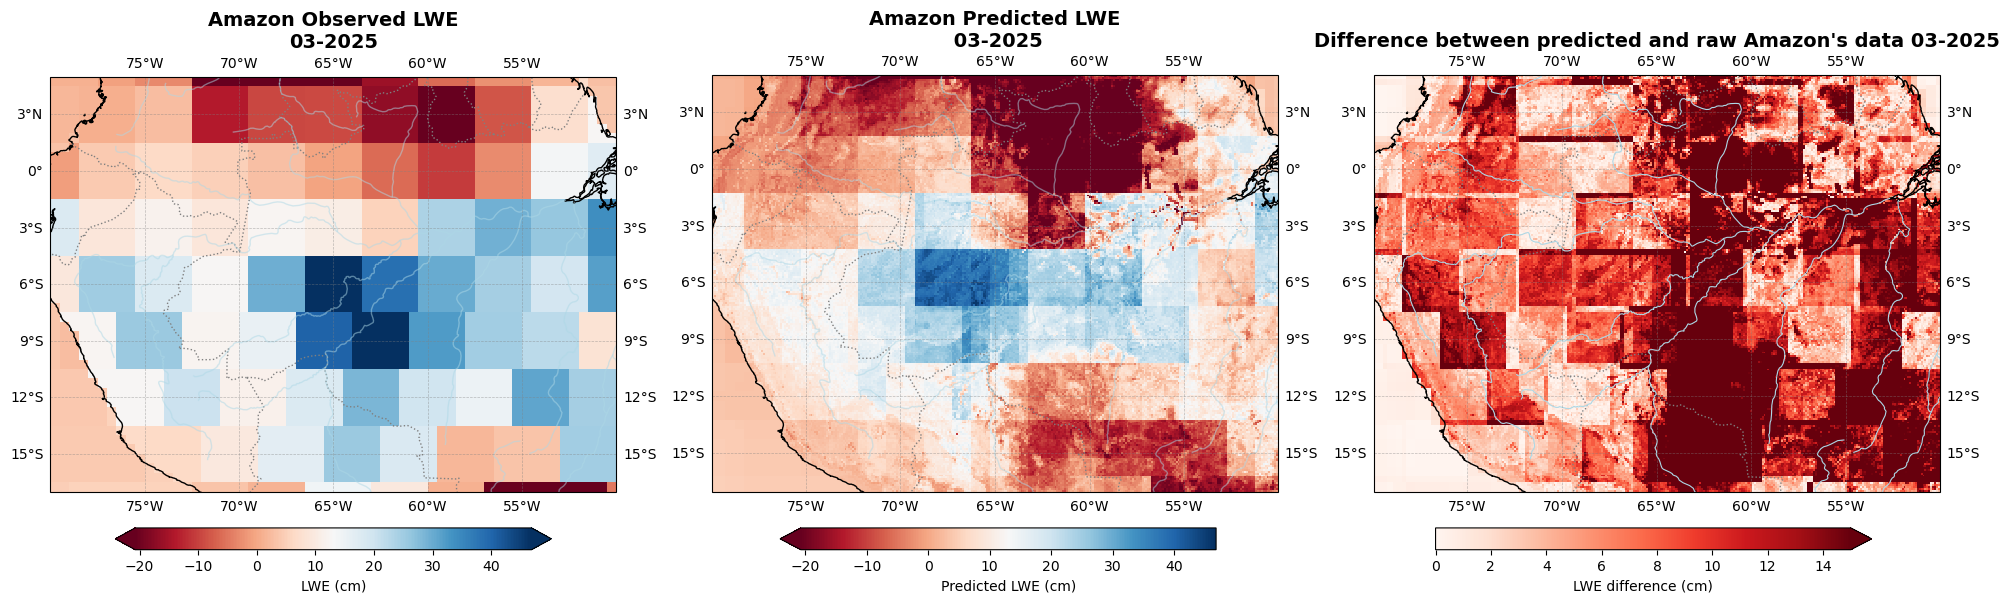

In [13]:
# Subplot raw_predict
models_dir = "../models/"
var_to_plot = "lwe_thickness"

# Select trained Model
print(f"\nScanning directory: {models_dir} ")
try:
    available_models = [f for f in os.listdir(models_dir) if f.endswith(".pkl")]
    if not available_models:
        print(Fore.RED + " Error: No .pkl files found in the models directory!")
        sys.exit()
# comment 
    print(" Available Models:")
    for i, model_file in enumerate(available_models):
        print(f"  [{i+1}] {model_file}")

    try:
        selection = int(input(f"\nSelect Model Number (1-{len(available_models)}): "))
        if 1 <= selection <= len(available_models):
            selected_model_name = available_models[selection - 1]
            full_model_path = os.path.join(models_dir, selected_model_name)
            print(f"  Selected: {selected_model_name}")
        else:
            print(Fore.RED + "  Invalid number selected. Exiting.")
            sys.exit()
    except ValueError:
        print(Fore.RED +"  Invalid input. Please enter a number.")
        sys.exit()

except FileNotFoundError:
    print(Fore.RED + f"  Error: Directory '{models_dir}' not found.")
    sys.exit()

# Load the chosen model
print(" Loading model...")
model = joblib.load(full_model_path)

try:
    basin_name = input("Enter Basin Name for the Title (e.g. Amazon, Lake Victoria): ").strip()
except ValueError:
    print(Fore.RED +" Invalid input! Terminating programm.")
    sys.exit()

# input date
try:
    map_year = int(input("Enter year: "))
    map_month = int(input("Enter month: "))
except ValueError:
    print(Fore.RED +" Invalid input! Terminating programm.")
    sys.exit()

target_ym = f"{map_year}-{map_month:02d}"

# Dynamic .jpg title approach
output_jpg_grace = f"../results/Comparison_GRACE_{basin_name}_{target_ym}_{selected_model_name}.jpg"
# Solving overwrite output problem 
i=1
while os.path.exists(output_jpg_grace):
    output_jpg_grace = f"../results/Comparison_GRACE_{basin_name}_{target_ym}_{selected_model_name}_{i}.jpg"
    i=i+1
else:
    print(f"Map saved to {output_jpg_grace}")
    
# -------------------------
# GRACE raw data (mask by year/month)
# -------------------------
t_index = pd.DatetimeIndex(ds_grace_JPL_sliced.time.values)
mask = (t_index.year == map_year) & (t_index.month == map_month)

if not mask.any():
    print(Fore.RED + f" Error: Grace data not found for {target_ym}")
    sys.exit()

# If there are multiple timestamps in the same month, pick the first
idx = int(np.where(mask)[0][0])

data_actual = ds_grace_JPL_sliced[var_to_plot].isel(time=idx)
picked_ts = pd.Timestamp(data_actual.time.values)
time_str = picked_ts.strftime("%Y-%m")

# -------------------------
# ERA5 data after prediction
# -------------------------
input_ERA_data = era5_df[(era5_df["year"] == map_year) & (era5_df["month"] == map_month)].copy()

if input_ERA_data.empty:
    print(Fore.RED + f" Error: ERA5 data not found for {target_ym}.")
    sys.exit()
else:
    try:
        required_features = model.feature_names_in_
    except AttributeError:
        print("Using default features")
        required_features = features

    missing_feats = [c for c in required_features if c not in input_ERA_data.columns]
    if missing_feats:
        raise KeyError(f"Missing required features in ERA5 input_data: {missing_feats}")

    X_pred = input_ERA_data[required_features]
    input_ERA_data["lwe_pred"] = model.predict(X_pred)

    ds_pred = input_ERA_data.groupby(["lat", "lon"])[["lwe_pred"]].mean().to_xarray()
    data_predicted = ds_pred["lwe_pred"]

# -------------------------
# lwe_difference
# -------------------------
input_diff_data = merged_4_diff[(merged_4_diff['year'] == map_year) & (merged_4_diff['month'] == map_month)]
if input_diff_data.empty:
    print(Fore.RED + f"No data found for {map_month}/{map_year}!")
    sys.exit()

ds_diff = input_diff_data.set_index(['lat', 'lon']).to_xarray()
data_slice_diff = ds_diff['lwe_difference']

# 4. Handle Time String Manually
# Since we lost the 'valid_time' column during earlier processing, we construct the string ourselves
time_str = f"{map_month:02d}-{map_year}" 

# Plot
vmin = data_actual.quantile(0.02).item()
vmax = data_actual.quantile(0.98).item()

fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(20, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# Map 1
data_actual.plot.pcolormesh(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap="RdBu",
    robust=True,
    cbar_kwargs={"label": "LWE (cm)", "orientation": "horizontal", "pad": 0.05, "fraction": 0.03},
    vmin=vmin, vmax=vmax
)
ax1.set_title(f"{basin_name} Observed LWE\n{time_str}", fontsize=14, fontweight="bold")
ax1.coastlines(resolution="10m")
ax1.add_feature(cfeature.BORDERS, linestyle=":", edgecolor='gray')
ax1.add_feature(cfeature.RIVERS, color="lightblue", alpha=0.5)
ax1.gridlines(draw_labels= True, linewidth=0.5, linestyle="--", alpha=0.5, color='gray')

# Map 2
data_predicted.plot.pcolormesh(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap="RdBu",
    robust=True,
    cbar_kwargs={"label": "Predicted LWE (cm)", "orientation": "horizontal", "pad": 0.05,"fraction": 0.03},
    vmin=vmin, vmax=vmax
)
ax2.set_title(f"{basin_name} Predicted LWE\n {time_str}", fontsize=14, fontweight="bold")
ax2.coastlines(resolution="10m")
ax2.add_feature(cfeature.BORDERS, linestyle=":", edgecolor='gray')
ax2.add_feature(cfeature.RIVERS, color="lightblue", alpha=0.5)
ax2.gridlines(draw_labels= True, linewidth=0.5, linestyle="--", alpha=0.5, color='gray')

# Map 3
# Note: data_slice is now an Xarray DataArray, so .plot works!
plot = data_slice_diff.plot.pcolormesh(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap="Reds",     
    robust=True,
    vmin=0 , vmax=15,    
    cbar_kwargs={"orientation": "horizontal", "fraction": 0.03,"pad": 0.05, "label": "LWE difference (cm)"}
    )

ax3.set_title(f"Difference between predicted and raw {basin_name}'s data {time_str}", fontsize=14, fontweight='bold')
ax3.coastlines(resolution="10m", color="black", linewidth=1)
ax3.add_feature(cfeature.BORDERS, linestyle=":", edgecolor='gray')
ax3.add_feature(cfeature.RIVERS, color='lightblue', linewidth=0.8)
ax3.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.savefig(output_jpg_grace, dpi=300, bbox_inches="tight")
print(f" Map saved to: {output_jpg_grace}")
plt.show()